# Quantum planning for swarm robotics

This notebook showcases the code used to develop, experiment, and simulate the swarm-planning quantum algorithm proposed in the article "__[Quantum planning for swarm robotics](https://doi.org/10.1016/j.robot.2023.104362)__". 

The problem instance that has been run is one of the most general ones described in section 4.2 of the cited paper, where the swarm size is restricted to 2 robots so that more than one full iteration is needed in order to achieve convergence.

The procedure is described in this file using Markdown to discuss the key points of the algorithm and also to comment on the obtained results, leaving to Python comments within the code cells the details of the implementation.

In [359]:
# qiskit tools for quantum circuit construction, visualization and simulation
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, transpile
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

# utilities 
from operator import attrgetter, itemgetter
from scipy.spatial.distance import cityblock
from heapq import nlargest
import numpy as np

## 1. Environment setup

Here we build the environment of our robotic swarm, composed of a 2D squared, unitary map over a fixed Cartesian coordinate system where the robots, obstacles and target will live in. We start by defining each of its entities and then initializing a map with the created instances in it.

### 1.1 Target & Reward

The target is the goal location $\textbf{g}$ that the algorithm directs the swarm to. It is fixed and set into one corner of the map:

$$ \textbf{g} = [0.875, 0.125] $$

which corresponds to the bottom-right corner of the squared, unitary world we are considering.

In [360]:
class Target:
    def __init__(self, name, x, y): # no indetermination in the target's position
        self.name = name
        self.x = x
        self.y = y

In [361]:
T = Target("T", 0.875, 0.125) # deep in the ocean

In this scenario, for the sake of explanation, we work under the assumption that the target position is known with full precision; practically, this information may not always be at our disposal. This is the reason why the algorithm mainly relies on the general proximity of the swarm to the target, rather than exact locations.

The reward is computed, for each swarm agent, through the (normalized) Euclidean distance between the target location, $\textbf{g}$, and the probability amplitude $\beta$ associated with the robot's position:

$$ reward(\textbf{g}, \beta) = 1 - \tfrac{\sqrt{\displaystyle (g_x - \beta_x)^2 + (g_y - \beta_y)^2}}{\sqrt{\displaystyle 2}} $$

translating to the reward being a number between $0$ and $1$ with a value that increases the closer a robot is to the target. Any other reward function that has the same behavior, wheter exploiting sensory data or some other external information also does the trick.

In [362]:
def reward(T, betax, betay):
    return 1 - (((T.x - betax)**2 + (T.y - betay)**2)**0.5)/np.sqrt(2) # distance is normalized on sqrt(2)

### 1.2 Obstacles

Obstacles are forbidden areas of the map, that should not be considered as either destination or as part of a robot's path. As described in section 3. of the paper, obstacles are considered od the same dimension order of the smallest micro-cells that the environment has been partitioned into. An obstacle that spans over more than one such cells is translated to a set of unit obstacles
on the respective cells it covers.

As for the target, their position is fixed, and in the case that dynamic obstacles are present, a new map with the updated structure is recomputed, according to the expected configuration.

In [363]:
class Obstacle:
    _registry = []

    def __init__(self, name, x, y):
        self._registry.append(self)
        self.name = name
        self.x = x
        self.y = y

In [364]:
O = Obstacle("Oo", 0.125, 0.125)

### 1.3 Robots

We consider a swarm of $N$ robots. Each of the $i$-th swarm entitity $R_i$ is defined as an object with the following attributes:
-  $\alpha^x_i$, $\beta^x_i$: probability amplitudes to find the robot in the left and right area of the map, respectively;
-  $\alpha^y_i$, $\beta^y_i$: same as above, but for a vertical subdivision of the map;
-  $\gamma_i$, $\delta_i$: amplitudes encoding the failure of success feedback calcualted on the basis of the robot's reward.

This information is encoded within qubit states as

$$ \begin{align*}
    |q_0\rangle &= \alpha^x_i|0\rangle + \beta^x_i|1\rangle \\
    |q_1\rangle &= \alpha^y_i|0\rangle + \beta^y_i|1\rangle \\
    |q_2\rangle &= \gamma_i|0\rangle + \delta_i|1\rangle
\end{align*} $$

where of course 

$$ \begin{align*}
&|\alpha^j_i|^2+|\beta^j_i|^2=1,\\&|\gamma_i|^2+|\delta_i|^2=1
\end{align*} $$ 

with $i=0, ..., N-1$ and $j=x,y$

In [365]:
# utility function that returns the complementary amplitude 
# of ampl, evaluated as sqrt(1 - ||ampl||^2)
#
def c_ampl(ampl):  
    return np.sqrt(1 - ampl**2)

In [366]:
class Robotx(object):
    _registry = []

    def __init__(self, name, alphax, alphay):
        self._registry.append(self)
        self.name = name
        self.alphax = alphax
        self.betax = c_ampl(alphax)
        self.alphay = alphay
        self.betay = c_ampl(alphay)
        self.delta = reward(T, self.betax, self.betay)
        self.gamma = c_ampl(self.delta)

### 1.4 Initialization and visualization

The swarm is initialized by specifying its size $N$ (`num_of_robots`). Initially, the robots are uniformly scattered over a single micro-cell, identified by its centroid.

In [367]:
# arbitrary number of robots that, at the start, are uniformly distributed 
# in the square of side length radius*2, centered in starting_cluster_coord
#
num_of_robots = 2

# must be lower than 0.25, otherwise, the robots would start on different cells
radius = 0.05

# center of the (0,0) cell 
starting_cluster_coord = (0.125, 0.875)

# boundaries to compute the initial random scattering on
a_x, a_y = c_ampl(starting_cluster_coord[0]-radius), c_ampl(starting_cluster_coord[0]+radius)
b_x, b_y = c_ampl(starting_cluster_coord[1]-radius), c_ampl(starting_cluster_coord[1]+radius)

# robots' initialization
for i in range(num_of_robots):
    Robotx('R'+str(i), np.random.uniform(a_x,a_y), np.random.uniform(b_x,b_y))

In [368]:
# note: values are stored with full precision, rounding is done only on visualization (with :.2f)
for k in Robotx._registry:
    print(f"{k.name} {k.betax:.2f} {k.betay:.2f} {k.gamma:.2f} {k.delta:.2f}")

R0 0.16 0.84 0.96 0.28
R1 0.17 0.92 0.97 0.25


In order to keep track of the performance of the algorithm, it will come in handy to also dispose of the average reward of the swarm, computed as the arithmetic mean over each of the robots' rewards. This value will provide us with information on the global behavior of the swarm, also allowing for a more direct comparison with other approaches.

In [369]:
def calculate_avg_reward():
    rewards = [robot.delta for robot in Robotx._registry]
    return np.mean(rewards)

print(f"Average reward: {calculate_avg_reward()}")

Average reward: 0.2661511086445497


In [370]:
# this utility function generates the visualization of the environment with each of the entitites;
# the map is maked with a squared lattice, so as to outline the micro-cell subdivision and the robots 
# obstacles, and target are color coded in the followig way:
#   robots: green circle;
#   obstacles: red pentagon;
#   target: turquoise star.
#
def plot_scatterplot(*args):

    # to print grid on map
    ax = plt.figure().gca()
    ax.set_xticks(np.arange(0, 1, 0.25))
    ax.set_yticks(np.arange(0, 1, 0.25))
    plt.grid()

    for i in Robotx._registry:
        # color gradient to better visualize the different robots within the map;
        # the higher the i-th index of the robot's name, the darker the green gradient.
        robot_color = hex(int("0x30ca15", 16) + int("0x00bb00", 16)*int(i.name[1])).replace("0x","#")
        plt.scatter(i.betax, i.betay, s = 300, marker = 'o', color = robot_color)
        
    plt.scatter(T.x, T.y, s = 400, marker = '*', color = 'turquoise')

    for o in Obstacle._registry:
        plt.scatter(o.x, o.y, s = 400, marker = 'p', color = 'red')

    plt.axis([0, 1, 0, 1])

    if args:
        plt.title(args[0])
        
    plt.show()

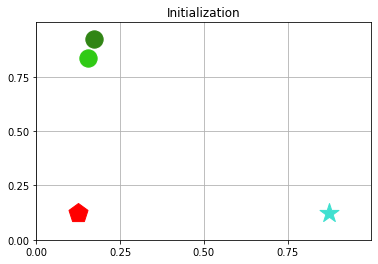

In [371]:
plot_scatterplot("Initialization")

This visualization shows our initialized environment, with the swarm in its starting point, far from the goal location that it has to reach. As we expect, each of the robots' rewards is low and not far from the other agents':

In [372]:
for r in Robotx._registry:
    if (r.delta < 0.5):
        print(f"{r.name} {r.delta:.2f} achtung!") # and start from this point to build the reshuffle section

R0 0.28 achtung!
R1 0.25 achtung!


## 2. Centroid handling

Centroids play a key role, as they are the mathematical representation of the map partitioning that we considered to improve the perfromance and accuracy of the algorithm. Generally, a centroid is an $s$-tuple with $s$ being the depth subdivision; in this case, as we are considering only an environment tessellated in macro- and micro-cells, we will have a $2$-tuple of the form

$$ (b_{micro}, b_{macro}) $$

with $b_{micro/macro}$ being the binary representation of the cell's coordinates, respectively for micro and macro cells.

Below we automatically generate a $2$-tuple of each of such cells of our partitioned map, also associating the binary form with the respective continuous coordinates of our reference system.

In [373]:
# returns a dict so that:
#  - the keys are the coordinates of the centroids of a square dim_map x dim_map map of side length 1
#  - the values are in the form (micro_cell, macro_cell) of the centroids
def find_centroids(dim_map):

    unit_displacement = 1 / (dim_map*2)

    centroids_coords = []
    for i in range(dim_map,0,-1):
        row = []
        for j in range(dim_map): 
            row.append((j*unit_displacement*2 + unit_displacement, i*unit_displacement*2 - unit_displacement))
        centroids_coords.append(row)

    centroids_dict = {t: (f"{str(i%2)}{str(j%2)}", f"{0 if t[1] > 0.5 else 1}{0 if t[0] < 0.5 else 1}")
     for i,row in enumerate(centroids_coords) for j,t in enumerate(row)}
     
    return centroids_dict

In [374]:
centroids = find_centroids(4)
print("Centroids:\n{ " + "\n  ".join(f"{k}: {v} " for k, v in centroids.items()) + "}")

Centroids:
{ (0.125, 0.875): ('00', '00') 
  (0.375, 0.875): ('01', '00') 
  (0.625, 0.875): ('00', '01') 
  (0.875, 0.875): ('01', '01') 
  (0.125, 0.625): ('10', '00') 
  (0.375, 0.625): ('11', '00') 
  (0.625, 0.625): ('10', '01') 
  (0.875, 0.625): ('11', '01') 
  (0.125, 0.375): ('00', '10') 
  (0.375, 0.375): ('01', '10') 
  (0.625, 0.375): ('00', '11') 
  (0.875, 0.375): ('01', '11') 
  (0.125, 0.125): ('10', '10') 
  (0.375, 0.125): ('11', '10') 
  (0.625, 0.125): ('10', '11') 
  (0.875, 0.125): ('11', '11') }


The discretization of the environment requires us to translate a continuous location into a discrete centroid, i.e., identifying a robot's position with the micro- and macro-cell coordinates, starting from its $\beta$ parameters.

In [375]:
# returns the centroid tuple of the cell that a point of coordinates (x,y) is located in
def find_closest_centroid(centroids, x, y):
    centroids_coords = np.array(list(centroids.keys()))
    distances = np.linalg.norm(centroids_coords-np.array([x, y]), axis=1)
    return centroids[tuple(centroids_coords[np.argmin(distances)])]

In [376]:
for r in Robotx._registry:
    print(f"Closest centroid to {r.name}: {find_closest_centroid(centroids, r.betax, r.betay)}")

Closest centroid to R0: ('00', '00')
Closest centroid to R1: ('00', '00')


As we expected, since the robots start in the upper-left corner of the map, they get to be associated with the `00` micro and `00` macro cells.

The same treatment will also be required for the obstacles:

In [377]:
# associate centroids to obstacles
obstacles_centroids = {coord: v for (coord,v) in centroids.items() for o in Obstacle._registry if coord == (o.x, o.y)}
print("Obstacles' centroids:\n{ " + "\n  ".join(f"{k}: {v} " for k, v in obstacles_centroids.items()) + "}")

Obstacles' centroids:
{ (0.125, 0.125): ('10', '10') }


## 3. Quantum path planning

This subsection implements the Grover-based path planning procedure described in the article __[A Quantum Planner for Robot Motion]( https://doi.org/10.3390/math10142475)__, which has been integrated in this study as the component that routes the robots on an optimal path to the destination evaluated by the swarm algorithm.

Before defining the procedure, we build a function that computes the $L^1$ Manhattan distance between two points $\textbf{p}$ and $\textbf{q}$, defined as:

$$ d_1(\textbf{p}, \textbf{q}) = || \textbf{p} - \textbf{q} ||_1 = \sum_i |p_i - q_i| $$ 

so that it is compatible with our intepretation of the map. This function is needed to dynamically build the quantum circuit that achieves the required robotic path planning, as the evaluated distance corresponds to the number of motion operators that make up the procedure.

In [378]:
# takes as input strings with the binary encoding of cells and outputs the manhattan distance between them
def manhattan(start_cell, target_cell):
    start_cell_v, target_cell_v = [int(b) for b in start_cell], [int(b) for b in target_cell]
    return int(cityblock(start_cell_v, target_cell_v).item())

The `GroverPlanner` class is written to handle any $2 \times 2$ map instance, and its `find_path(start_cell, target_cell, m_type)` method dynamically adapts to the length of the trajectory as well as the presence of obstacles and movement type ("macro" or "micro").

In [379]:
class GroverPlanner:
    def __init__(self, obstacles):
        self.simulator = Aer.get_backend("aer_simulator")
        self.obstacles = obstacles

    #
    # Utility functions
    #
    def XOR(self, qc, a, b, output):
        qc.cx(a, output)
        qc.cx(b, output)

    def encode_cell(self, qc, cell, qubits):
        for idx, bit in enumerate(cell):
            bitn = int(bit)
            if bitn:
                qc.x(qubits[idx])

    def encode_target(self, qc, target_cell, qubits):
        for idx, bit in enumerate(target_cell):
            bitn = int(bit)
            if not bitn:
                qc.x(qubits[idx])

    def obstacles_in_map(self, target_cell):
        return any(target_cell[1] == macro_cell for macro_cell in list(map(lambda ob_t: ob_t[1], self.obstacles)))

    #
    # Grover diffuser
    #
    def diffuser(self, nqubits):
        diff = QuantumCircuit(nqubits)

        # Apply transformation |s> -> |00..0> (H-gates)
        for qubit in range(nqubits):
            diff.h(qubit)

        # Apply transformation |00..0> -> |11..1> (X-gates)
        for qubit in range(nqubits):
            diff.x(qubit)

        # Do multi-controlled-Z gate
        diff.h(nqubits - 1)
        diff.mct(list(range(nqubits - 1)), nqubits - 1)  # multi-controlled-toffoli
        diff.h(nqubits - 1)

        # Apply transformation |11..1> -> |00..0>
        for qubit in range(nqubits):
            diff.x(qubit)

        # Apply transformation |00..0> -> |s>
        for qubit in range(nqubits):
            diff.h(qubit)
        
        U_s = diff.to_gate()
        U_s.name = "U$_\psi$"
        return U_s

    #
    # Half oracle
    #
    # it performs the quantum moves to get to the final state the solution test is performed on; its structure 
    # changes according to both the number of movements required to get to the target and the presence of obstacles
    #
    def half_oracle(self, num_of_M, obstacles_in_map, quantum_registers):

        if num_of_M == 1:

            ho = QuantumCircuit(*quantum_registers)
            pos_qubits, mov_qubits, c, output = quantum_registers

            # -- First M --
            self.XOR(ho, pos_qubits[1], mov_qubits[0], c[0])
            ho.x(c[0])
            self.XOR(ho, pos_qubits[0], mov_qubits[0], c[1])

        elif num_of_M == 2:

            ho = QuantumCircuit(*quantum_registers)

            if obstacles_in_map:
                pos_qubits, mov_qubits, c, o, caux, out, output = quantum_registers
            else:
                pos_qubits, mov_qubits, c, output = quantum_registers

            # -- First M --
            self.XOR(ho, pos_qubits[1], mov_qubits[0], c[0])
            ho.x(c[0])
            self.XOR(ho, pos_qubits[0], mov_qubits[0], c[1])

            if obstacles_in_map:
                # -- Obstacle encoding --
                for obstacle in self.obstacles:
                    self.encode_cell(ho, obstacle[0], [c[0], c[1]])
                    ho.ccx(c[0], c[1], o)
                    self.encode_cell(ho, obstacle[0], [c[0], c[1]])

            # -- Second M --
            self.XOR(ho, c[1], mov_qubits[1], c[2])
            ho.x(c[2])
            self.XOR(ho, c[0], mov_qubits[1], c[3])

            if obstacles_in_map:
                # -- Selection stage --
                ho.ccx(c[2], o, caux[0])
                ho.x(caux[0])
                ho.ccx(c[3], o, caux[1])
                ho.x(caux[1])

                ho.x(o)

                ho.ccx(pos_qubits[0], o, caux[2])
                ho.x(caux[2])
                ho.ccx(pos_qubits[1], o, caux[3])
                ho.x(caux[3])

                ho.ccx(caux[0], caux[2], out[0])
                ho.x(out[0])
                ho.ccx(caux[1], caux[3], out[1])
                ho.x(out[1])

        HalfOracle = ho.to_gate()
        HalfOracle.name = "HO"
        return HalfOracle

    #
    # Grover oracle
    #
    # it is composed of a oracle half, the testing operator, and the mirror circuit of the first half
    #
    def oracle(self, num_of_M, target_cell, m_type, obstacles_in_map, qc, quantum_registers):

        halforacle = self.half_oracle(num_of_M, obstacles_in_map, quantum_registers)

        additional_regs = []

        if obstacles_in_map:
            pos_qubits, mov_qubits, c, *additional_regs, output = quantum_registers
        else:
            pos_qubits, mov_qubits, c, output = quantum_registers

        # -- First half of the oracle --
        qc.append(
            halforacle,
            pos_qubits[:]
            + mov_qubits[:]
            + c[:]
            + (
                (additional_regs[0][:] + additional_regs[1][:] + additional_regs[2][:])
                if additional_regs
                else []
            )
            + output[:],
        )

        # -- Test operator --
        test_qubits = c[-2:] if num_of_M == 1 or (num_of_M == 2 and not obstacles_in_map) else additional_regs[2]
        tcell_idx = 0 if m_type == "micro" else 1
        self.encode_target(qc, target_cell[tcell_idx], [test_qubits[0], test_qubits[1]])
        qc.ccx(test_qubits[0], test_qubits[1], output)
        self.encode_target(qc, target_cell[tcell_idx], [test_qubits[0], test_qubits[1]])

        # -- Mirror circuit of the first half of the oracle --
        qc.append(
            halforacle.inverse(),
            pos_qubits[:]
            + mov_qubits[:]
            + c[:]
            + (
                (additional_regs[0][:] + additional_regs[1][:] + additional_regs[2][:])
                if additional_regs
                else []
            )
            + output[:],
        )

    #
    # Path planning
    #
    # takes as input the tuples of centroids start_cell and target_cell, together with the movement type (m_type),
    # that can yield the values "micro" or "macro"
    #
    def find_path(self, start_cell, target_cell, m_type):

        # number of M operators is equal to the Manhattan distance between start and target
        cell_idx = 0 if m_type == "micro" else 1
        num_of_M = manhattan(start_cell[cell_idx], target_cell[cell_idx])

        # --- Initializations ---
        pos_qubits = QuantumRegister(2, name="r")
        mov_qubits = QuantumRegister(num_of_M, name="m")
        c = QuantumRegister(2 * num_of_M, name="c")

        o = QuantumRegister(1, name="o")
        caux = QuantumRegister(4, name="caux")
        out = QuantumRegister(2, name="out")

        output = QuantumRegister(1, name="q")
        cbits = ClassicalRegister(2 + num_of_M, name="cbits")

        # check if there are obstacles to be considered within the path
        obstacles_in_map = self.obstacles_in_map(target_cell) and m_type == "micro"

        # ensemble of quantum registers to build the QuantumCircuit with
        base_registers = [pos_qubits, mov_qubits, c, output, cbits]
        additional_registers = base_registers.copy()
        additional_registers[3:3] = [o, caux, out]
        quantum_registers = (
            base_registers
            if num_of_M == 1 or (num_of_M == 2 and not obstacles_in_map)
            else additional_registers
        )

        qc = QuantumCircuit(*quantum_registers)

        # initialize pos_qubits in uniform superposition
        qc.h(pos_qubits)

        # initialize mov_qubits in state |s>
        qc.h(mov_qubits)

        # initialize 'output0' in state |->
        qc.initialize([1, -1] / np.sqrt(2), output)

        # --- Oracle + Diffuser ---
        num_iterations = 1
        for _ in range(num_iterations):
            self.oracle(
                num_of_M,
                target_cell,
                m_type,
                obstacles_in_map,
                qc,
                quantum_registers[:-1],
            )
            diff_qubits = [0, 1, 2] if num_of_M == 1 else [0, 1, 2, 3]
            qc.append(self.diffuser(len(diff_qubits)), diff_qubits)

        # --- Measurement ---
        qc.measure(pos_qubits, cbits[0:2])
        qc.measure(mov_qubits, cbits[2 : (2 + num_of_M)])

        # --- Simulation ---
        transpiled_qc = transpile(qc, self.simulator)
        result_counts = self.simulator.run(transpiled_qc).result().get_counts()

        # filtering out all the non-trivial solutions on the simulation output
        return [k for k in result_counts.keys() if k[-2:] == start_cell[cell_idx][len(start_cell[cell_idx]) :: -1]]

groverPlanner = GroverPlanner(obstacles_centroids.values())

In [380]:
# test
groverPlanner.find_path(start_cell=("00", "00"), target_cell=("00", "01"), m_type="macro")

['100']

The test above is an example of macro-only displacement, i.e., one where a robot has moved to another macro-cell, but remaining in the same (relative) micro-cell, as depicted in the following figure:


![my_image](./imgs/macro-only.png)

The path to follow in order to reach that destination starting from the macro-cell `00` is represented by a single clockwise rotation, encoded with the `1` leftmost output of the `find_path()` method.

## 4. Reshuffling

This is the stage where the robots wander randomly through the map, evaluating their rewards on the new positions, so that the most successful ones (those that are the closest to the target) can be extracted and used to route the entire swarm toward a location that has a greater proximity to the goal.

First, a new random position is calculated for each robot; then, a centroid is associated to it, together with the (discrete displacement) with respect to the starting position. This information is used to discriminate between the micro and macro nature of the path that connects the two locations, which sets up the quantum path planning procedure for computing the actual path.

In [381]:
# returns a list with the micro and macro displacement after the movement
def eval_displacement(old_centroid, new_centroid):
    old_c_micro, old_c_macro = old_centroid
    new_c_micro, new_c_macro = new_centroid
    return [manhattan(old_c_micro, new_c_micro), manhattan(old_c_macro, new_c_macro)]

In [382]:
# computes the movements required to get to the position encoded in new_alphas, which has the form [new_alphax, new_alphay]
#
# it also updates the new position of the robot, so there is no need to do that separately
#
def compute_path_to_position(robot, new_alphas):

    # starting centroid
    old_centroid = find_closest_centroid(centroids, robot.betax, robot.betay)

    # assign new positions
    robot.alphax, robot.alphay = new_alphas
    robot.betax, robot.betay = c_ampl(robot.alphax), c_ampl(robot.alphay)

    # new centroid
    new_centroid = find_closest_centroid(centroids, robot.betax, robot.betay)

    # displacement between the new and starting centroids
    displacement = eval_displacement(old_centroid, new_centroid)

    #
    # Planning the path according to the different possible displacement:
    #   - macro: the robot changes macro-cell but stays in the same micro-cell
    #   - micro: the robot changes micro-cell but stays in the same macro-cell
    #   - macro and micro: the robot changes both macro and micro cells
    #   - if the new position is in the same micro and macro cells nothing happens
    # 

    # --- Macro movement ---
    if displacement[0] == 0 and displacement[1] != 0:
        print(f"{robot.name}: macro")
        evaluated_path = groverPlanner.find_path(old_centroid, new_centroid, m_type="macro")
        print(f"{robot.name} evaluated path: {evaluated_path[0][:-2]}")

    # --- Micro movement ---
    elif displacement[0] != 0 and displacement[1] == 0:
        print(f"{robot.name}: micro")
        evaluated_path = groverPlanner.find_path(old_centroid, new_centroid, m_type="micro")
        print(f"{robot.name} evaluated path: {evaluated_path[0][:-2]}")

    # --- Macro and micro movement ---
    elif displacement[0] != 0 and displacement[1] != 0:
        print(f"{robot.name}: macro-micro")
        # macro path
        evaluated_path = groverPlanner.find_path(old_centroid, new_centroid, m_type="macro")
        print(f"{robot.name} evaluated path (macro): {evaluated_path[0][:-2]}")
    
        # micro path
        evaluated_path = groverPlanner.find_path(old_centroid, new_centroid, m_type="micro")
        print(f"{robot.name} evaluated path (micro): {evaluated_path[0][:-2]}")

We also incorporate a check on whether an evaluated position ends up in an obstacle cell, with the `is_position_on_obstacle(new_alphas)` method. If that was the case, the new position is discarded and recomputed. This is done to improve the efficiency of the algorithm, avoiding the construction and execution of a Grover procedure that searches a path toward a forbidden location.

In [383]:
# check whether a given position ends up in a obstacle cell
def is_position_on_obstacle(new_alphas):
    new_pos_centroid = find_closest_centroid(centroids, c_ampl(new_alphas[0]), c_ampl(new_alphas[1]))
    return True if new_pos_centroid in obstacles_centroids.values() else False

In the interest of enahncing the convergence speed of the algorithm, the reshuffling is done in a goal-oriented manner, i.e.,  it is evaluated over the sub-rectangle pinpointed by the micro-cells of the target $\textbf{g}$ and the robot with lowest reward, `farthest_robot` (i.e., the farthest from the goal, with the idea of maximum coverage of the working map to restrict the occurrence of local minima). Here, in view of the fact that the swarm and the target have been initialized in opposite corners of the map, the sub-rectangle defined by the farthest robot and the target of the informed reshuffling is indeed the entire map.

In [384]:
def informed_alpha_reshuffling():

    # parse the coordinates of farthest robot from the target
    #
    # since this method is called when the robots are in a cluster (either at the start or ar the end
    # of a full procedure), it does not matter which robot is chosen, all being quite close to each other;
    # here, among all, I am choosing the farthest one with the idea of "maximum coverage" of the search space
    #
    farthest_robot = min(Robotx._registry, key=attrgetter('delta'))
    f_centroid = find_closest_centroid(centroids, farthest_robot.betax, farthest_robot.betay)
    f_coords = list(list(centroids.keys())[list(centroids.values()).index(f_centroid)])

    # handle the case where the robot lies in the same row/column of the target
    if f_coords[0] == T.x:
        f_coords[0] = f_coords[1]
    elif f_coords[1] == T.y:
        f_coords[1] = f_coords[0]

    # compute the new reshuffled position within the rectangle 
    return [c_ampl(np.random.uniform(f_coords[0], T.x)), c_ampl(np.random.uniform(f_coords[1], T.y))]

Generally speaking, the reshuffling is invoked whenever none of the robots has a sufficient proximity to the target, which right after the initialization stage, is trivially true.

In [385]:
result = all(i.delta < 0.8 for i in Robotx._registry)
print("Do all the robots have a reward lower than 0.8? : " + str(result))

# if True: reshuffle positions
# if False: do nothing

# reshuffling is considered invalid if the target position of the robot is the same as that of an obstacle;
# with this consideration, no computational time is wasted trying to find the path to an inaccessible cell

if result == True:
    for i in Robotx._registry:
        new_alphas = informed_alpha_reshuffling()

        # if new position ends up in an obstacle cell, recompute the alphas
        while is_position_on_obstacle(new_alphas):
            new_alphas = informed_alpha_reshuffling()

        compute_path_to_position(i, new_alphas)          

Do all the robots have a reward lower than 0.8? : True
R0: micro
R0 evaluated path: 00
R1: macro
R1 evaluated path: 00


After each time the robots change position, we re-evaluate their individual and average rewards, to check if indeed the swarm has moved closer to the target, which we can mathematically verify by observing an higher average reward with respect to the previous one.

In [386]:
# recalculate the rewards
def recalculate_rewards():
    for i in Robotx._registry:
        i.delta = reward(T, i.betax, i.betay)
        i.gamma = c_ampl(i.delta)
        print(f"{i.name} {i.delta:.2f}")

In [387]:
recalculate_rewards()
print(f"Average reward: {calculate_avg_reward()}")

R0 0.46
R1 0.71
Average reward: 0.5851850527375524


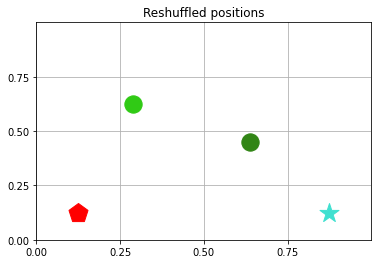

In [388]:
plot_scatterplot("Reshuffled positions")

## 5. Quantum swarm algorithm

Here we implement the swarm algorithm defined in __[Categories, Quantum Computing, and Swarm Robotics: A Case Study.](https://doi.org/10.3390/math10030372)__ and __Modeling and Designing a Robotic Swarm: a Quantum Computing Approach__. This procedure models the pairwise interaction between robots on target proximity to evaluate where the swarm needs to move to in order to improve its overall reward.

### 5.1 Circuit construction and execution

In [389]:
q = QuantumRegister(5, 'q') # qubits # changed to 9, formerly 15
m2 = ClassicalRegister(1, 'c1') # classical bits (separated is better)
m3 = ClassicalRegister(1, 'c2')
m4 = ClassicalRegister(1, 'c3')
meas = ClassicalRegister(3, 'meas')

qc3 = QuantumCircuit(q, m2, m3, m4) # to reach the target
qc4 = QuantumCircuit(q, m2, m3, m4) # to get back to the nest

The first step in this section corresponds to extracting $R_{closest}$, the robot that is closest to the target, so that its parameters can be fed as input to the quantum algorithm. Such robot is selected based on the highest success reward $\delta$ out of all of the components of the swarm.

In [390]:
# utility function to better visualize the statevectors we are working with
def print_formatted_vector(*args):
    for vector in args:
        print("[" + "".join(f"{val:.2f} " for val in vector).strip() + "]")

In [391]:
# in case of ties on delta score, the max() function outputs the first maximum item it processes 
closest_robot = max(Robotx._registry, key=attrgetter('delta'))
print(f"Closest robot to the target: {closest_robot.name} {closest_robot.betax:.2f} {closest_robot.betay:.2f} {closest_robot.delta:.2f}")

# and then it enters the gate
vector0 = [closest_robot.alphax, closest_robot.betax]
vector1 = [closest_robot.alphay, closest_robot.betay]
vector3 = [closest_robot.gamma, closest_robot.delta]

normalized_v0 = vector0/np.linalg.norm(vector0)
normalized_v1 = vector1/np.linalg.norm(vector1)
normalized_v3 = vector3/np.linalg.norm(vector3)

print_formatted_vector(vector0, vector1, vector3)
print_formatted_vector(normalized_v0, normalized_v1, normalized_v3)

Closest robot to the target: R1 0.64 0.45 0.71
[0.77 0.64]
[0.89 0.45]
[0.70 0.71]
[0.77 0.64]
[0.89 0.45]
[0.70 0.71]


The qubits' statevector get initialized with the normalized states computed over the closest robot, and then the rest of the circuit is constructed.

In [392]:
# direct initialization with amplitudes vector
qc3.initialize(normalized_v0, q[0])
qc3.initialize(normalized_v1, q[1])
qc3.initialize(normalized_v3, q[2])

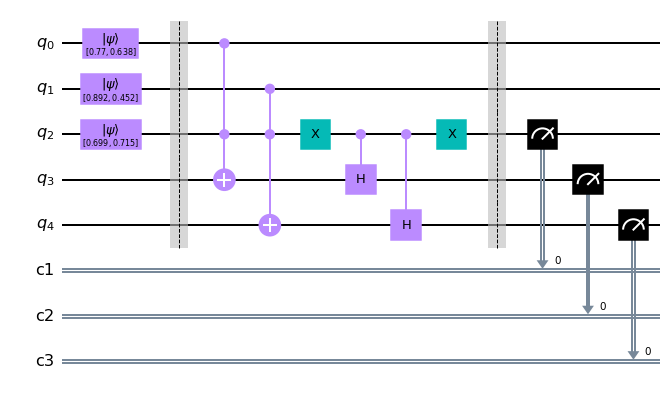

In [393]:
# this is the core code, and it is unchanged across time
#
qc3.barrier(q)

qc3.ccx(q[0],q[2],q[3]) 
qc3.ccx(q[1],q[2],q[4])

qc3.x(q[2])

qc3.ch(q[2],q[3])
qc3.ch(q[2],q[4])

qc3.x(q[2])

qc3.barrier(q)

# perform measurements and store them in classical bits
qc3.measure(q[2],m2[0])
qc3.measure(q[3],m3[0])
qc3.measure(q[4],m4[0])

# visualization of the ciruit
qc3.draw(output="mpl")

counts:  {'0 0 1': 227, '0 1 1': 185, '1 1 0': 133, '0 1 0': 124, '1 1 1': 38, '0 0 0': 137, '1 0 0': 121, '1 0 1': 59}


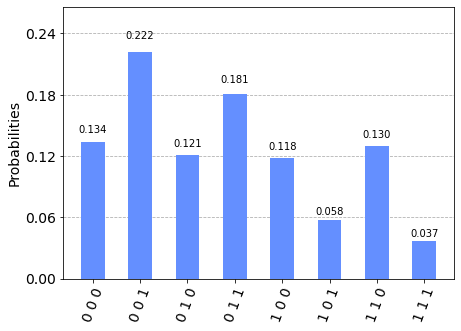

In [394]:
# --- Simulation ---
aer_sim = Aer.get_backend("aer_simulator")
transpiled_qc = transpile(qc3, aer_sim)
result = aer_sim.run(transpiled_qc).result()

counts = result.get_counts()
print("counts: ", counts)

plot_histogram(result.get_counts())

### 5.2 Outcome evaluation

The most probable states we got from running the simulation are then used to evaluate the outcome of the algorithm

In [395]:
# calculate weighted outcome on the most probables outcomes of the circuit
def eval_outcome(most_prob_dict, n_outcome):
    mapped_weights = list(map(lambda res: int(res[n_outcome*2])*most_prob_dict[res], most_prob_dict))
    return sum(mapped_weights)/sum(most_prob_dict.values())

In [396]:
num_most_prob_states = 4

# extract the most probable states and then evaluate the outcome
most_prob_dict = dict(nlargest(num_most_prob_states, counts.items(), key=itemgetter(1)))
print(f"{num_most_prob_states} most probable states: {most_prob_dict}")

outcome0, outcome1 = eval_outcome(most_prob_dict, 0), eval_outcome(most_prob_dict, 1)

print(f"outcome0: {outcome0:.2f}\noutcome1: {outcome1:.2f}")

4 most probable states: {'0 0 1': 227, '0 1 1': 185, '0 0 0': 137, '1 1 0': 133}
outcome0: 0.20
outcome1: 0.47


### 5.3 Setting new positions after the gate

Once we parsed the desired evaluated position, we make the robots move toward it, also involving a path-planning stage to again compute the best trajectory to reach the destination.

In [397]:
for i in Robotx._registry:
    print(f"{i.name} {i.betax:.2f} {i.betay:.2f}")
    if (i.delta != closest_robot.delta or all(i.delta == j.delta for j in Robotx._registry)): # excluding the robot that entered the gate
        compute_path_to_position(i, [c_ampl(outcome1), c_ampl(outcome0)]) # update on alphas is done within the function

R0 0.29 0.62
R0: macro
R0 evaluated path: 0
R1 0.64 0.45


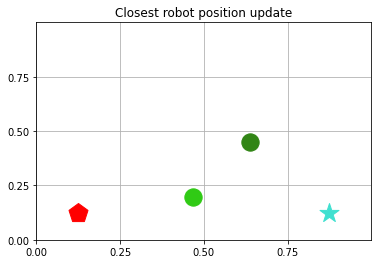

In [398]:
plot_scatterplot("Closest robot position update")

In [399]:
# former rewards 
for i in  Robotx._registry:
    print(f"before the gate: {i.name} {i.delta:.2f}")

before the gate: R0 0.46
before the gate: R1 0.71


In [400]:
# new rewards
recalculate_rewards()
print(f"Average reward: {calculate_avg_reward()}")

R0 0.71
R1 0.71
Average reward: 0.7107238904343017


We can see that we have yet improved our score on the average reward of the swarm.

### 5.4 Reaching the new $R_{closest}$

Once the swarm has been re-routed by the swarm algorithm, potentially a new $R_{closest}$ emerges, and so the rest of the robots ought to reach it, in the optimal way.

In [401]:
# parse the most successful robot
max_attr_ = max(Robotx._registry, key=attrgetter('delta'))
print(f"max_attr_.delta: {max_attr_.delta:.2f}")

for i in Robotx._registry:
    if (i.delta == max_attr_.delta):
        print(f"Most successful robot: {i.name} {i.betax:.2f} {i.betay:.2f} {i.delta:.2f}") # and then it enters the gate

for j in Robotx._registry:
    # to get other robots following it:
    if (j != max_attr_): 
        compute_path_to_position(j, [max_attr_.alphax + np.random.uniform(0,0.01), max_attr_.alphay + np.random.uniform(0,0.01)])

max_attr_.delta: 0.71
Most successful robot: R1 0.64 0.45 0.71
R0: macro-micro
R0 evaluated path (macro): 0
R0 evaluated path (micro): 11


In [402]:
recalculate_rewards()
print(f"Average reward: {calculate_avg_reward()}")

R0 0.72
R1 0.71
Average reward: 0.7161468976475711


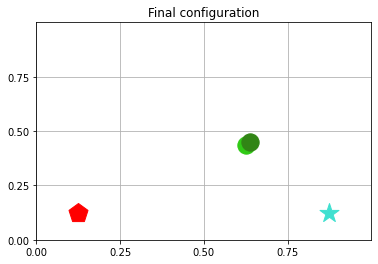

In [403]:
plot_scatterplot("Final configuration")

## 6. Additional algorithm iteration

From the final configuration, we saw that while the swarm has indeed moved closer to the target, its position is still far from the actual goal, this is why, in the case that at the end of the procedure we evaluate each of the robots’ rewards to be below the threshold $\theta = 0.8$ (which assimilates to a good enough proximity to the target), we perform another iteration of the algorithm to get as near to the goal as possible. This is repeated until the threshold value is reached by at least one of the robots.

In [404]:
for i in Robotx._registry:
    if (i.delta < 0.8):
 
        new_alphas = informed_alpha_reshuffling()

        # if new position ends up in an obstacle cell, recompute the alphas
        while is_position_on_obstacle(new_alphas):
                new_alphas = informed_alpha_reshuffling()

        compute_path_to_position(i, new_alphas)

R0: micro
R0 evaluated path: 11


In [405]:
recalculate_rewards()

R0 0.96
R1 0.80


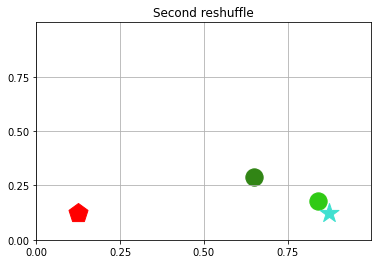

In [406]:
plot_scatterplot("Second reshuffle")

In [407]:
# parse the most successful robot
max_attr_ = max(Robotx._registry, key=attrgetter('delta'))
print(f"max_attr_.delta: {max_attr_.delta:.2f}")

for i in Robotx._registry:
    if (i.delta == max_attr_.delta):
        print(f"Most successful robot: {i.name} {i.betax:.2f} {i.betay:.2f} {i.delta:.2f}") # and then it enters the gate

for j in Robotx._registry:
    # to get other robots following it:
    if (j != max_attr_): 
        compute_path_to_position(j, [max_attr_.alphax + np.random.uniform(0,0.01), max_attr_.alphay + np.random.uniform(0,0.01)])   

max_attr_.delta: 0.96
Most successful robot: R0 0.84 0.18 0.96
R1: micro
R1 evaluated path: 00


In [408]:
recalculate_rewards()

R0 0.96
R1 0.96


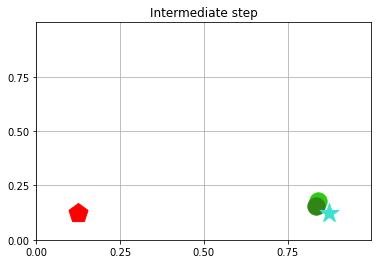

In [409]:
plot_scatterplot("Intermediate step")

Here, the quantum swarm algorithm is invoked yet another time.

In [410]:
# in case of ties on delta score, the max() function outputs the first maximum item it processes 
closest_robot = max(Robotx._registry, key=attrgetter('delta'))
print(f"Closest robot to the target: {closest_robot.name} {closest_robot.betax:.2f} {closest_robot.betay:.2f} {closest_robot.delta:.2f}")

# and then it enters the gate
vector0 = [closest_robot.alphax, closest_robot.betax]
vector1 = [closest_robot.alphay, closest_robot.betay]
vector3 = [closest_robot.gamma, closest_robot.delta]

normalized_v0 = vector0/np.linalg.norm(vector0)
normalized_v1 = vector1/np.linalg.norm(vector1)
normalized_v3 = vector3/np.linalg.norm(vector3)

print_formatted_vector(vector0, vector1, vector3)
print_formatted_vector(normalized_v0, normalized_v1, normalized_v3)

Closest robot to the target: R1 0.84 0.16 0.96
[0.55 0.84]
[0.99 0.16]
[0.26 0.96]
[0.55 0.84]
[0.99 0.16]
[0.26 0.96]


In [411]:
# direct initialization with amplitudes vector
qc3.initialize(normalized_v0, q[0])
qc3.initialize(normalized_v1, q[1])
qc3.initialize(normalized_v3, q[2])

In [412]:
# this is the core code, and it is unchanged across time

qc3.barrier(q)

qc3.ccx(q[0],q[2],q[3]) 
qc3.ccx(q[1],q[2],q[4])

qc3.x(q[2])

qc3.ch(q[2],q[3])
qc3.ch(q[2],q[4])

qc3.x(q[2])

qc3.barrier(q)

In [413]:
# perform measurements and store them in classical bits

qc3.measure(q[2],m2[0])
qc3.measure(q[3],m3[0])
qc3.measure(q[4],m4[0])

counts:  {'0 1 1': 328, '1 1 1': 185, '1 0 1': 169, '0 0 1': 265, '0 1 0': 18, '0 0 0': 21, '1 1 0': 21, '1 0 0': 17}


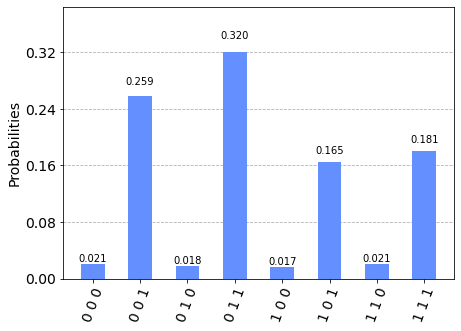

In [414]:
# --- Simulation ---
transpiled_qc = transpile(qc3, aer_sim)
result = aer_sim.run(transpiled_qc).result()

counts = result.get_counts()
print("counts: ", counts)

plot_histogram(result.get_counts())

In [415]:
# extract the most probable states and then evaluate the outcome
most_prob_dict = dict(nlargest(num_most_prob_states, counts.items(), key=itemgetter(1)))
print(f"{num_most_prob_states} most probable states: {most_prob_dict}")

outcome0, outcome1 = eval_outcome(most_prob_dict, 0), eval_outcome(most_prob_dict, 1)

print(f"outcome0: {outcome0:.2f}\noutcome1: {outcome1:.2f}")

4 most probable states: {'0 1 1': 328, '0 0 1': 265, '1 1 1': 185, '1 0 1': 169}
outcome0: 0.37
outcome1: 0.54


In [416]:
for i in Robotx._registry:
    print(f"{i.name} {i.betax:.2f} {i.betay:.2f}")
    if (i.delta != closest_robot.delta or all(i.delta == j.delta for j in Robotx._registry)): # excluding the robot that entered the gate
        compute_path_to_position(i, [c_ampl(outcome1), c_ampl(outcome0)]) # update on alphas is done within the function

R0 0.84 0.18
R0: micro
R0 evaluated path: 00
R1 0.84 0.16


In [417]:
# former rewards 
for i in  Robotx._registry:
    print(f"before the gate: {i.name} {i.delta:.2f}")

before the gate: R0 0.96
before the gate: R1 0.96


In [418]:
# new rewards
print("Rewards after the gate: ")
recalculate_rewards()

Rewards after the gate: 
R0 0.71
R1 0.96


In [419]:
# parse the most successful robot
max_attr_ = max(Robotx._registry, key=attrgetter('delta'))
print(f"max_attr_.delta: {max_attr_.delta:.2f}")

for i in Robotx._registry:
    if (i.delta == max_attr_.delta):
        print(f"Most successful robot: {i.name} {i.betax:.2f} {i.betay:.2f} {i.delta:.2f}") # and then it enters the gate

for j in Robotx._registry:
    # to get other robots following it:
    if (j != max_attr_): 
        compute_path_to_position(j, [max_attr_.alphax + np.random.uniform(0,0.01), max_attr_.alphay + np.random.uniform(0,0.01)])

max_attr_.delta: 0.96
Most successful robot: R1 0.84 0.16 0.96
R0: micro
R0 evaluated path: 11


In [420]:
recalculate_rewards()

R0 0.97
R1 0.96


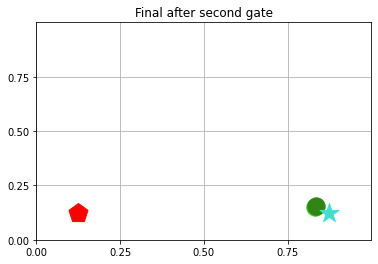

In [421]:
plot_scatterplot("Final after second gate")

The swarm has reached the desired proximity to the goal, and therefore the algorithm can halt.